# Imports

In [649]:
# Import the necessary libraries
from PIL import Image
import scipy
import matplotlib.pyplot as plt
import numpy as np

# Definindo funções

Funções usadas para o tratamento das imagens

In [650]:
def imread(file_path):
    return np.array(Image.open(file_path))

def im2double(img):
    return img.astype(float) / 255

Função utilizada para codificar a mensagem (encode), ou seja, esconder a mensagem na imagem

In [651]:
def encoding(imgem, blockSize, msgBytes, RGB = 0, singular_value=-1):
    isBreaking = False
    img = imgem.copy()
    imgResult = img
    byte = 0
    bit = 0
    count = 0
    height, width, dim = img.shape
    errorList = []
    sigmas_list = []
    sigmas_list_coded = []

    for i in range(height//blockSize):
        for j in range(width//blockSize):
            U, S, V = scipy.linalg.svd(img[blockSize*i:blockSize*i+blockSize, blockSize*j:blockSize*j+blockSize, RGB])
            S_copy = S.copy()
            S_result = S.copy()
            sigmas_list.append(S_copy)

            bitAtual= msgBytes[byte][bit]

            k = 0

            if bitAtual == "1":
                S_result[singular_value] = 0

            elif bitAtual == "0":

                while k < blockSize:
                    if S_result[k] <= 1e-10:
                        S_result[k] = S_result[k-1] / 5
                    k+=1

            elif bitAtual == "2":
                sigmas_list_coded.append(S_result)
                isBreaking = True
                break


            A = np.dot(U, np.dot(np.diag(S_result), V))
            sigmas_list_coded.append(S_result)

            errorList.append(np.linalg.norm(np.dot(U, np.dot(np.diag(S_copy), V)) - A))

            img[blockSize*i:blockSize*i+blockSize, blockSize*j:blockSize*j+blockSize, RGB] = A

            bit += 1

            if bit == 8:
                bit = 0
                byte+=1

            count+=1

        if isBreaking:
            break


    return img, errorList, sigmas_list, sigmas_list_coded

Função para decodificar a mensagem (decode), ou seja, encontrar a mensagem escondida

In [652]:
def decoding(hidImg, blockSize, msgSize, RGB = 0, singular_value=-1):
    NewM = []
    height, width, dim = hidImg.shape

    for i in range(height//blockSize):
        for j in range(width//blockSize):
            U, S, V = scipy.linalg.svd(hidImg[blockSize*i:blockSize*i+blockSize, blockSize*j:blockSize*j+blockSize, RGB])

            if S[singular_value] <= 1e-10:
                NewM.append("1")
            elif S[singular_value] >= 1e-10:
                NewM.append("0")

    # Make new message legible
    StegM = "Message: "

    for i in range(0, 8*msgSize, 8):
        b = ''.join(NewM[i:i+8])
        a = int(b, 2)
        l = chr(a)
        StegM += l

    print(StegM)

# Lendo imagem e definindo mensagem

Lendo a imagem

In [653]:
limg = ['dogXS.jpg', 'birdXS.jpg', 'cat_gF.jpg', 'flowerS.jpg', 'flowerL.jpg', 'tigerS.png', 'tigerL.png', 'birdS.jpg', 'birdB.jpg','cat_kayden.jpg', 'lizzard.png', 'water.png', 'white_cat.jpg', 'witch.jpg']
I = imread('./images/'+ limg[1])
I1 = im2double(I)

Definindo a mensagem

In [654]:
Msg = 'Os grandes espíritos sempre sofreram oposição violenta das mentes medíocres. Estas últimas não conseguem entender quando um homem não se submete.'

Função de tratamento da mensagem 

In [655]:
def transformMsg(M):
    lm = len(M)
    MNum = np.array([ord(c) for c in M])
    MNumFinal = np.array([format(num, '08b') for num in MNum]).flatten()
    Emp = []

    for a in range(lm):
        Emp.append(MNumFinal[a])

    Emp.append('2')

    return Emp, lm

Transformando a mensagem e inicializando variáveis importantes

In [656]:
Emp, lm = transformMsg(Msg)

height, width, dim = I.shape

# Realizando a esteganografia

## Teste 1

Aplicando a função de encode (escondendo a mensagem)

In [657]:
teste1, erros1, sList1, sListCoded1 = encoding(I1, 2, Emp)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


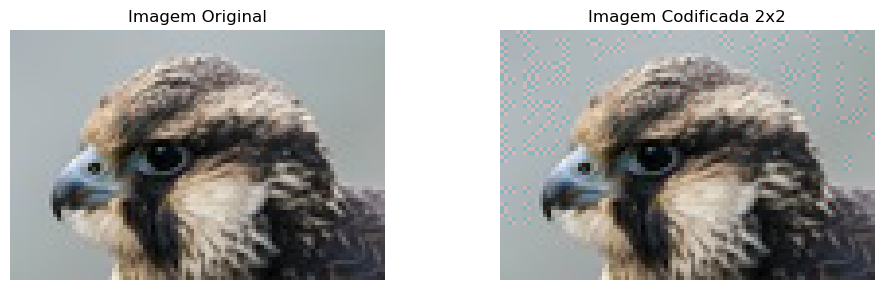

In [658]:
# Visualizando as mudanças na imagem:
fig, axes = plt.subplots(1, 2, figsize=(10, 3))

# imagem original
axes[0].imshow(I)
axes[0].set_title("Imagem Original")
axes[0].axis('off')

# imagem codificada
axes[1].imshow(teste1)
axes[1].set_title("Imagem Codificada 2x2")
axes[1].axis('off')

plt.tight_layout()
plt.show()


Observando a segunda imagem conseguimos perceber mudanças em certos quadrantes, pois a mensagem está sendo escondida em tais blocos.<br><br> É importante notar que observamos uma alteração pequena, visto que estamos alterando o valor singular de menor expressão.<br>

Aplicando a função de decode (revelando a mensagem)

In [659]:
decoding(teste1, 2, lm)

Message: Os grandes espíritos sempre sofreram oposição violenta das mentes medíocres. Estas últimas não conseguem entender quando um homem não se submete.


### Erro



Diferença entre a imagem original e imagem alterada (mensagem escondida)

In [660]:
np.linalg.norm(I1 - teste1)

3.2661356913343718

### Diferença dos valores singulares (SVD)

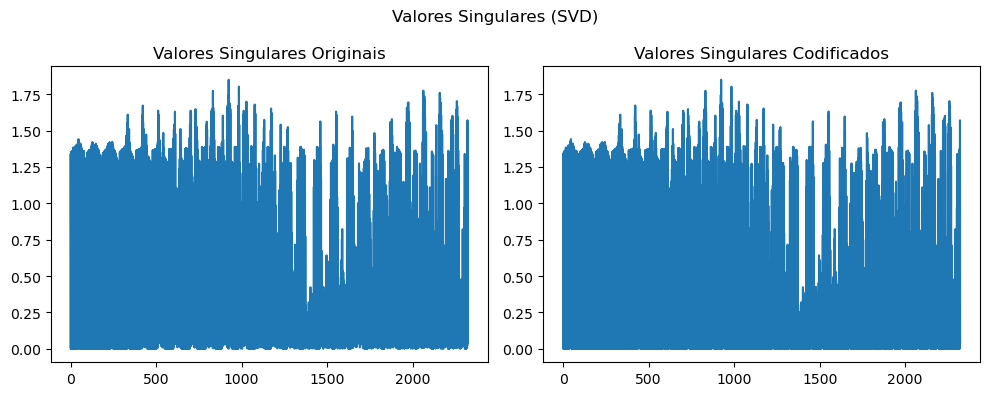

In [661]:
#Visualizando a mudança nos valores singulares
valores_singulares_originais1 = np.array(sList1).flatten()
valores_singulares_codificados1 = np.array(sListCoded1).flatten()

fig, axs = plt.subplots(1, 2,  figsize=(10, 4))
fig.suptitle("Valores Singulares (SVD)")

# Plot os valores singulares da imagem original
axs[0].plot(valores_singulares_originais1, label='Original')
axs[0].set_title('Valores Singulares Originais')

# Plot os valores singulares depois da codificação
axs[1].plot(valores_singulares_codificados1, label='Encoded')
axs[1].set_title('Valores Singulares Codificados')

plt.tight_layout()
plt.show()

Note que observando os dois gráficos somos capazes de perceber pequenas mudanças (quase impreceptíveis), pois estamos alterando o valor singular menos significante

Aqui estamos nos certificando que realmente existe diferença entre os valores singulares da imagem original e da imagem codificada

In [662]:
dif1 = np.abs(valores_singulares_originais1 - valores_singulares_codificados1)
sum(dif1)

49.897871889719475

Plotando a diferença dos valores singulares

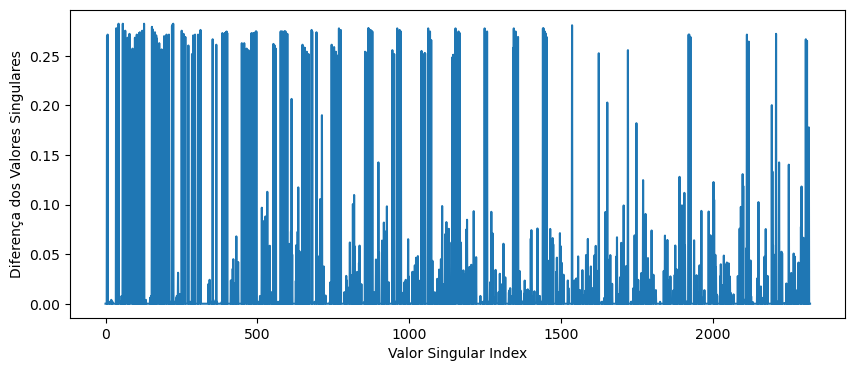

In [663]:
plt.figure(figsize=(10, 4))
plt.plot(dif1, label='Diferença dos Valores Singulares')
plt.xlabel('Valor Singular Index')
plt.ylabel('Diferença dos Valores Singulares')
plt.show()

In [664]:
len(valores_singulares_codificados1)

2322

## Teste 2

Definindo a mensagem

In [665]:
msg2 = 'Msg Pequena'
Emp2, lm2 = transformMsg(msg2)

Executando a função de encode com diferentes tamanhos de blocos. (Descomente para observar melhor as mudanças)

In [666]:
teste21, erros21, sList21, sListCoded21 = encoding(I1, 2, Emp2)
teste22, erros22, sList22, sListCoded22 = encoding(I1, 4, Emp2)
teste23, erros23, sList23, sListCoded23 = encoding(I1, 8, Emp2)

#teste21, erros21, sList21, sListCoded21 = encoding(I1, 2, Emp2, 0, 0)
#teste22, erros22, sList22, sListCoded22 = encoding(I1, 4, Emp2, 0, 0)
#teste23, erros23, sList23, sListCoded23 = encoding(I1, 8, Emp2, 0, 0)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


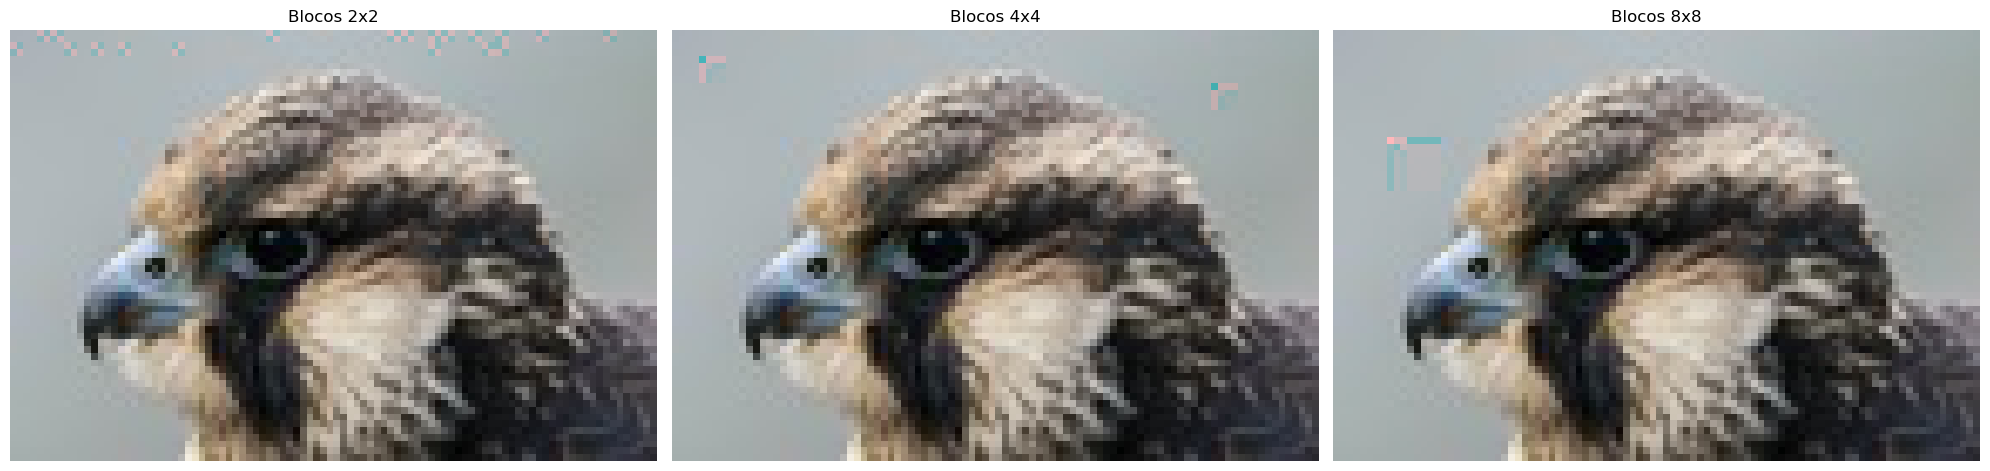

In [667]:
# Visualizando as mudanças nas imagens:
fig, axes = plt.subplots(1, 3, figsize=(20, 5))


# bloco 2x2
axes[0].imshow(teste21)
axes[0].set_title('Blocos 2x2')
axes[0].axis('off')  # Desabilitar os eixos

# bloco 4x4
axes[1].imshow(teste22)
axes[1].set_title('Blocos 4x4')
axes[1].axis('off')  # Desabilitar os eixos

# bloco 8x8
axes[2].imshow(teste23)
axes[2].set_title('Blocos 8x8')
axes[2].axis('off')  # Desabilitar os eixos

# Ajustar o layout da figura
plt.tight_layout()
plt.show()

In [668]:
decoding(teste21, 2, lm2)

Message: Msg Pequena


In [669]:
decoding(teste22, 4, lm2)

Message: Msg Pequena


In [670]:
decoding(teste23, 8, lm2)

Message: Msg Pequena


### Erros



In [671]:
np.linalg.norm(I1 - teste21)

1.1882532760840445

In [672]:
np.linalg.norm(I1 - teste22)

0.7669522595846551

In [673]:
np.linalg.norm(I1 - teste23)

1.1248750724155214

Interessante observar que o erro diminui de acordo com o tamanho dos blocos. Isso ocorre, pois dependendo das dimensões dos blocos podemos selecionar por acaso blocos que ja escondem a mensagem "naturalmente".<br><br>
Por exemplo: na hora de esconder um bit de valor 1 ou 0 o bloco não precisou ser mudado pois seu quarto valor singular já obedecia os requisitos da função de encode. 

### Diferença dos valores singulares (SVD)

#### Teste 2.1

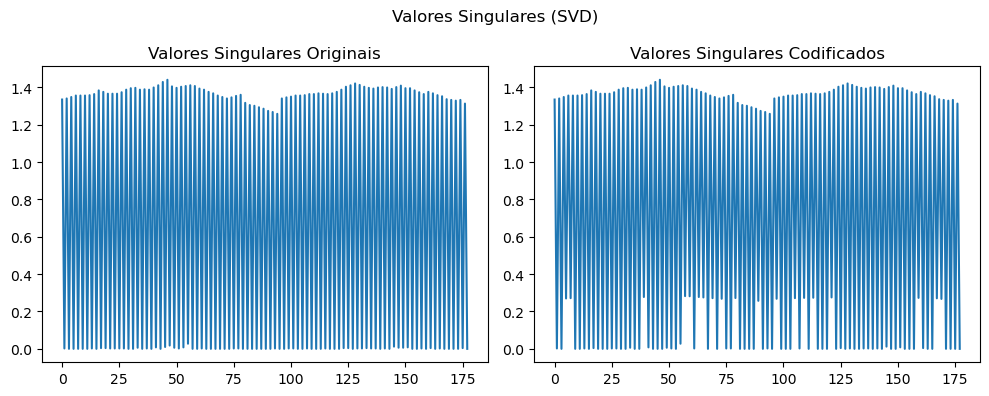

In [674]:
#Visualizando a mudança nos valores singulares
valores_singulares_originais21 = np.array(sList21).flatten()
valores_singulares_codificados21 = np.array(sListCoded21).flatten()

fig, axs = plt.subplots(1, 2,  figsize=(10, 4))
fig.suptitle("Valores Singulares (SVD)")

# Plot os valores singulares da imagem original
axs[0].plot(valores_singulares_originais21, label='Original')
axs[0].set_title('Valores Singulares Originais')

# Plot os valores singulares depois da codificação
axs[1].plot(valores_singulares_codificados21, label='Encoded')
axs[1].set_title('Valores Singulares Codificados')

plt.tight_layout()
plt.show()

In [675]:
dif21 = np.abs(valores_singulares_originais21 - valores_singulares_codificados21)

In [676]:
sum(dif21)

5.257975334520383

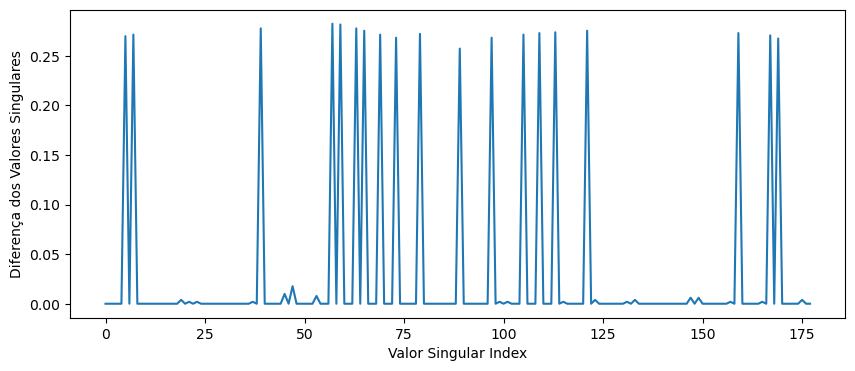

In [677]:
plt.figure(figsize=(10, 4))
plt.plot(dif21, label='Diferença dos Valores Singulares')
plt.xlabel('Valor Singular Index')
plt.ylabel('Diferença dos Valores Singulares')
plt.show()

In [678]:
len(valores_singulares_codificados21)

178

#### Teste 2.2

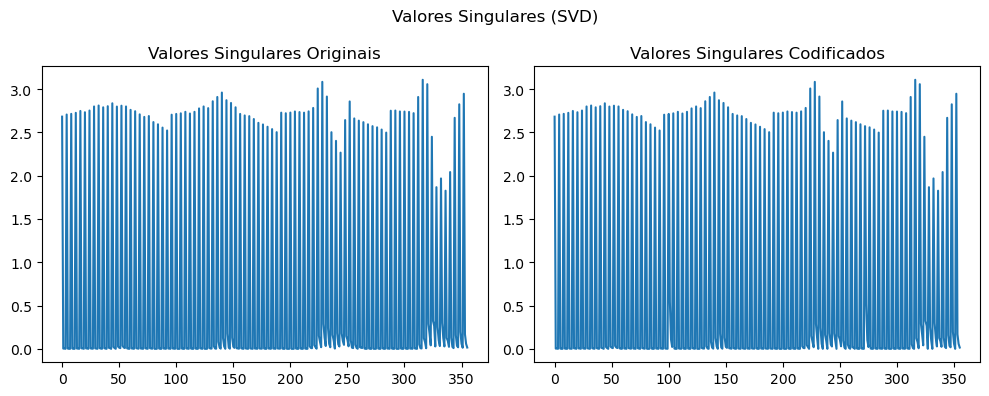

In [679]:
#Visualizando a mudança nos valores singulares
valores_singulares_originais22 = np.array(sList22).flatten()
valores_singulares_codificados22 = np.array(sListCoded22).flatten()

fig, axs = plt.subplots(1, 2,  figsize=(10, 4))
fig.suptitle("Valores Singulares (SVD)")

# Plot os valores singulares da imagem original
axs[0].plot(valores_singulares_originais22, label='Original')
axs[0].set_title('Valores Singulares Originais')

# Plot os valores singulares depois da codificação
axs[1].plot(valores_singulares_codificados22, label='Encoded')
axs[1].set_title('Valores Singulares Codificados')

plt.tight_layout()
plt.show()

In [680]:
dif22 = np.abs(valores_singulares_originais22 - valores_singulares_codificados22)

In [681]:
sum(dif22)

1.5217160315640483

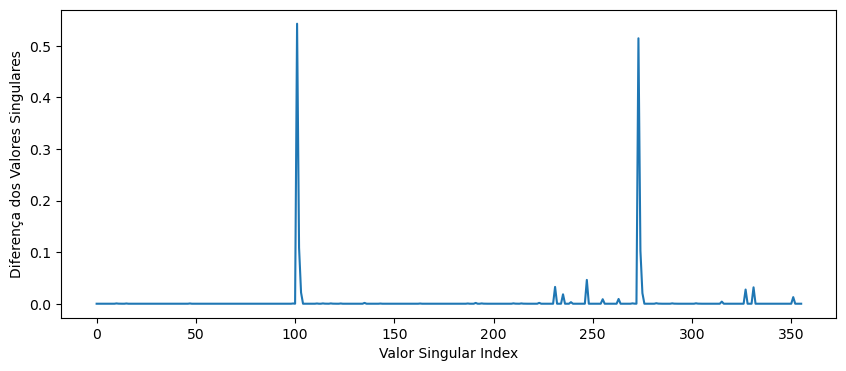

In [682]:
plt.figure(figsize=(10, 4))
plt.plot(dif22, label='Diferença dos Valores Singulares')
plt.xlabel('Valor Singular Index')
plt.ylabel('Diferença dos Valores Singulares')
plt.show()

In [683]:
len(valores_singulares_codificados22)

356

#### Teste 2.3

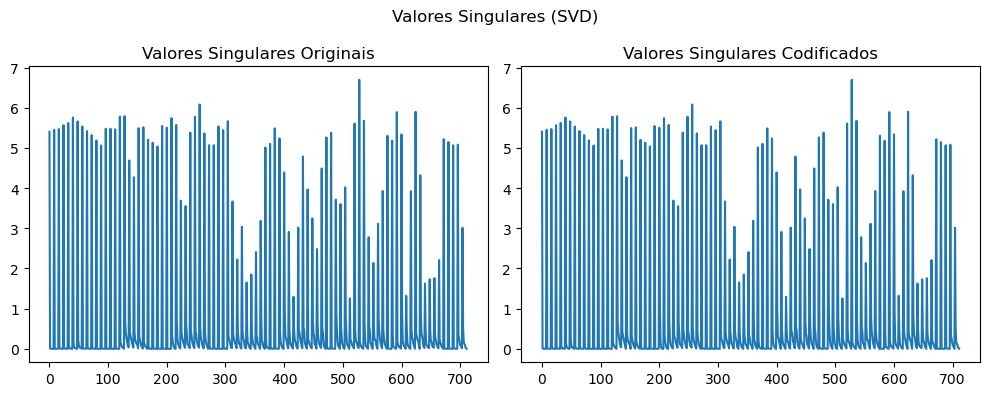

In [684]:
#Visualizando a mudança nos valores singulares
valores_singulares_originais23 = np.array(sList23).flatten()
valores_singulares_codificados23 = np.array(sListCoded23).flatten()

fig, axs = plt.subplots(1, 2,  figsize=(10, 4))
fig.suptitle("Valores Singulares (SVD)")

# Plot os valores singulares da imagem original
axs[0].plot(valores_singulares_originais23, label='Original')
axs[0].set_title('Valores Singulares Originais')

# Plot os valores singulares depois da codificação
axs[1].plot(valores_singulares_codificados23, label='Encoded')
axs[1].set_title('Valores Singulares Codificados')

plt.tight_layout()
plt.show()

In [685]:
dif23 = np.abs(valores_singulares_originais23 - valores_singulares_codificados23)

In [686]:
sum(dif23)

1.6054736917381307

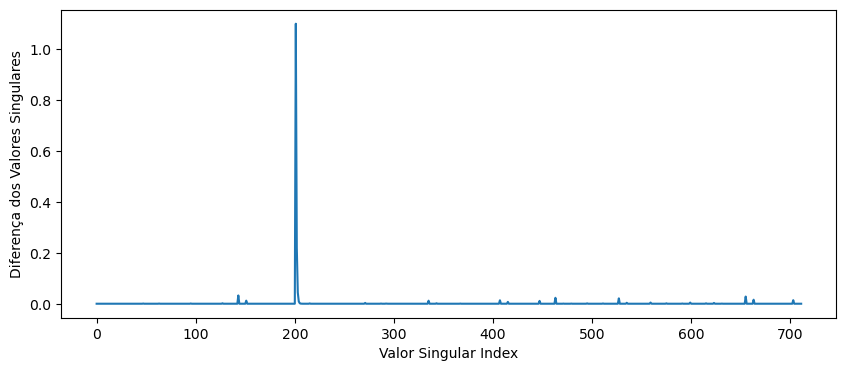

In [687]:
plt.figure(figsize=(10, 4))
plt.plot(dif23, label='Diferença dos Valores Singulares')
plt.xlabel('Valor Singular Index')
plt.ylabel('Diferença dos Valores Singulares')
plt.show()

Observação: Apesar de sList21, sList22, sList23 e sList1 serem as listas de valores singulares de uma mesma imagem, isso NÂO significa que as listas possuem o mesmo tamanho.Isso ocorre, pois o tamanho da mensagem altera a quantidade de valores singulares percorridos no processo de codificação, ou seja, a lista de valores singulares fica menor conforme o tamanho da mensagem. (Vide a diferença de densidade nos gráficos que dizem respeito aos valores singulares).

## Teste 3

Alterando o primeiro valor singular ao invés do último.

In [688]:
msg3 = 'Agora vamos tentar alterar o primeiro valor singular e ver como ativamente os valores singulares tem poder sobre uma imagem!'
Emp3, lm3 = transformMsg(msg3)

In [689]:
teste3, erros3, sList3, sListCoded3 = encoding(I1, 2, Emp3, 0, 0)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


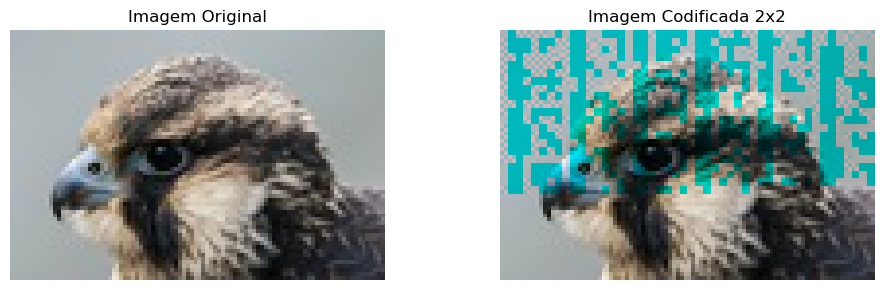

In [690]:
# Visualizando as mudanças na imagem:
fig, axes = plt.subplots(1, 2, figsize=(10, 3))

# imagem original
axes[0].imshow(I)
axes[0].set_title("Imagem Original")
axes[0].axis('off')

# imagem codificada
axes[1].imshow(teste3)
axes[1].set_title("Imagem Codificada 2x2")
axes[1].axis('off')

plt.tight_layout()
plt.show()


In [691]:
decoding(teste3, 2, lm3)

Message: Agora vamos tentar alterar o primeiro valor singular e ver como ativamente os valores singulares tem poder sobre uma imagem!


### Erro

In [692]:
np.linalg.norm(I1 - teste3)

26.63699722823958

### Diferença dos valores singulares

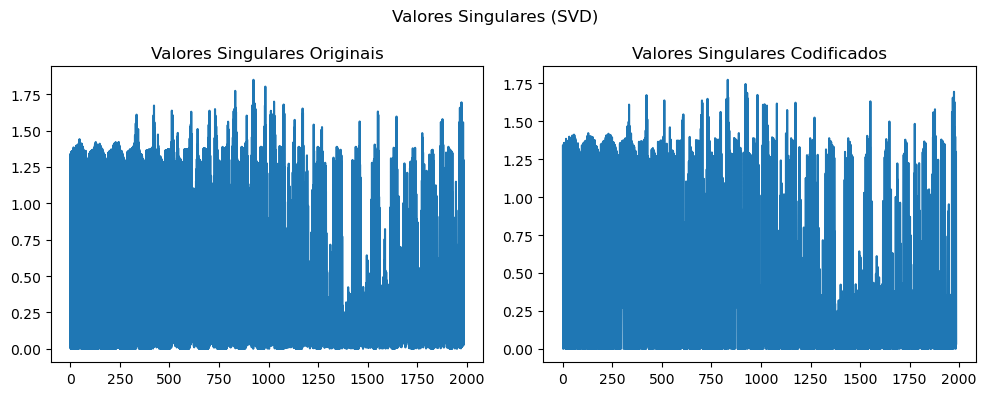

In [693]:
#Visualizando a mudança nos valores singulares
valores_singulares_originais3 = np.array(sList3).flatten()
valores_singulares_codificados3 = np.array(sListCoded3).flatten()

fig, axs = plt.subplots(1, 2,  figsize=(10, 4))
fig.suptitle("Valores Singulares (SVD)")

# Plot os valores singulares da imagem original
axs[0].plot(valores_singulares_originais3, label='Original')
axs[0].set_title('Valores Singulares Originais')

# Plot os valores singulares depois da codificação
axs[1].plot(valores_singulares_codificados3, label='Encoded')
axs[1].set_title('Valores Singulares Codificados')

plt.tight_layout()
plt.show()

In [694]:
dif3 = np.abs(valores_singulares_originais3 - valores_singulares_codificados3)

In [695]:
sum(dif3)

580.0791146392302

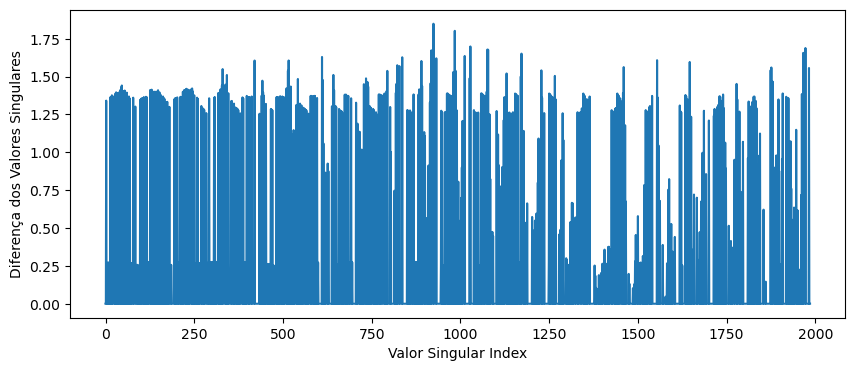

In [696]:
plt.figure(figsize=(10, 4))
plt.plot(dif3, label='Diferença dos Valores Singulares')
plt.xlabel('Valor Singular Index')
plt.ylabel('Diferença dos Valores Singulares')
plt.show()

## Teste 4

In [697]:
I2 = imread('./images/preto.jpg')
I2 = im2double(I2)

In [698]:
msg4 = 'Agora vamos tentar utilizar o codigo em uma imagem sem valores singulares!'
Emp4, lm4 = transformMsg(msg4)

In [699]:
teste4, erros4, sList4, sListCoded4 = encoding(I2, 2, Emp4)

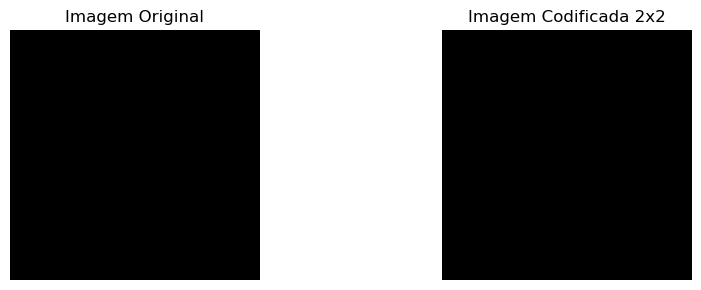

In [700]:
# Visualizando as mudanças na imagem:
fig, axes = plt.subplots(1, 2, figsize=(10, 3))

# imagem original
axes[0].imshow(I2)
axes[0].set_title("Imagem Original")
axes[0].axis('off')

# imagem codificada
axes[1].imshow(teste4)
axes[1].set_title("Imagem Codificada 2x2")
axes[1].axis('off')

plt.tight_layout()
plt.show()


In [701]:
decoding(teste4, 2, lm4)

Message: ÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿ


A função falha em decodificar na imagem preta, pois todos os seus valores singulares são zero.

### Erro

In [702]:
np.linalg.norm(I2 - teste4)

0.0

### Diferença dos valores singulares

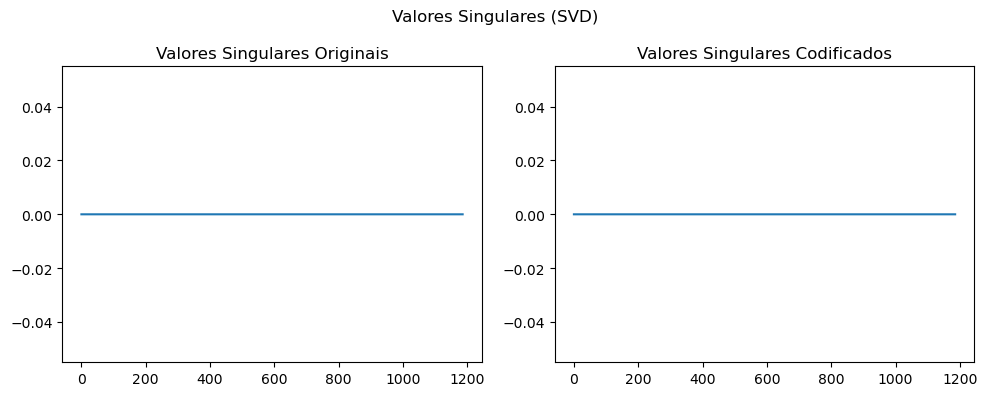

In [703]:
#Visualizando a mudança nos valores singulares
valores_singulares_originais4 = np.array(sList4).flatten()
valores_singulares_codificados4 = np.array(sListCoded4).flatten()

fig, axs = plt.subplots(1, 2,  figsize=(10, 4))
fig.suptitle("Valores Singulares (SVD)")

# Plot os valores singulares da imagem original
axs[0].plot(valores_singulares_originais4, label='Original')
axs[0].set_title('Valores Singulares Originais')

# Plot os valores singulares depois da codificação
axs[1].plot(valores_singulares_codificados4, label='Encoded')
axs[1].set_title('Valores Singulares Codificados')

plt.tight_layout()
plt.show()

In [704]:
dif4 = np.abs(valores_singulares_originais4 - valores_singulares_codificados4)

In [705]:
sum(dif4)

0.0

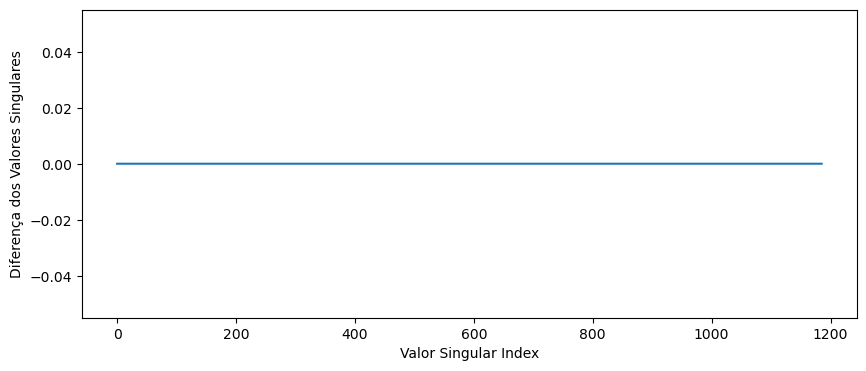

In [706]:
plt.figure(figsize=(10, 4))
plt.plot(dif4, label='Diferença dos Valores Singulares')
plt.xlabel('Valor Singular Index')
plt.ylabel('Diferença dos Valores Singulares')
plt.show()

## Teste 5

In [707]:
I3 = imread('./images/lizzard.png')
I3 = im2double(I3)

In [708]:
msg5 = 'Agora vamos mostrar a eficiencia do codigo em uma imagem com maior qualidade e uma mensagem de tamanho maior, e por fim encerrar nossos teste. Obrigada pela atenção!'
Emp5, lm5 = transformMsg(msg5)

In [709]:
teste51, erros51, sList51, sListCoded51 = encoding(I3, 2, Emp5)
teste52, erros52, sList52, sListCoded52 = encoding(I3, 4, Emp5)
teste53, erros53, sList53, sListCoded53 = encoding(I3, 8, Emp5)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


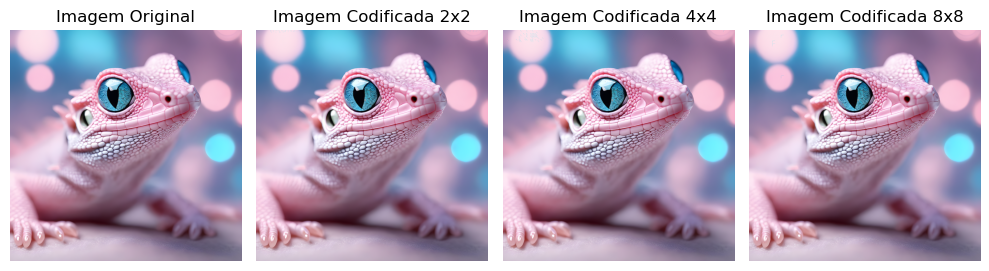

In [710]:
# Visualizando as mudanças na imagem:
fig, axes = plt.subplots(1, 4, figsize=(10, 3))

# imagem original
axes[0].imshow(I3)
axes[0].set_title("Imagem Original")
axes[0].axis('off')

# imagem codificada
axes[1].imshow(teste51)
axes[1].set_title("Imagem Codificada 2x2")
axes[1].axis('off')

# imagem codificada
axes[2].imshow(teste52)
axes[2].set_title("Imagem Codificada 4x4")
axes[2].axis('off')

# imagem codificada
axes[3].imshow(teste53)
axes[3].set_title("Imagem Codificada 8x8")
axes[3].axis('off')

plt.tight_layout()
plt.show()


In [711]:
decoding(teste51, 2, lm5)

Message: Agora vamos mostrar a eficiencia do codigo em uma imagem com maior qualidade e uma mensagem de tamanho maior, e por fim encerrar nossos teste. Obrigada pela atenção!


In [712]:
decoding(teste52, 4, lm5)

Message: Agora vamos mostrar a eficiencia do codigo em uma imagem com maior qualidade e uma mensagem de tamanho maior, e por fim encerrar nossos teste. Obrigada pela atenção!


In [713]:
decoding(teste53, 8, lm5)

Message: Agora vamos mostrar a eficiencia do codigo em uma imagem com maior qualidade e uma mensagem de tamanho maior, e por fim encerrar nossos teste. Obrigada pela atenção!


### Erros

In [714]:
np.linalg.norm(I3 - teste51)

4.735827387511745

In [715]:
np.linalg.norm(I3 - teste52)

5.638939728378249

In [716]:
np.linalg.norm(I3 - teste53)

3.2340389929438293

### Diferença dos valores singulares

#### Teste 5.1

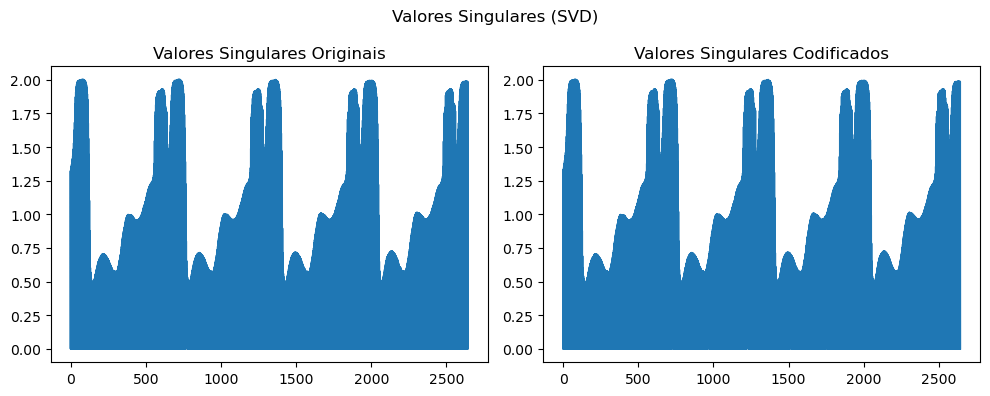

In [717]:
#Visualizando a mudança nos valores singulares
valores_singulares_originais51 = np.array(sList51).flatten()
valores_singulares_codificados51 = np.array(sListCoded51).flatten()

fig, axs = plt.subplots(1, 2,  figsize=(10, 4))
fig.suptitle("Valores Singulares (SVD)")

# Plot os valores singulares da imagem original
axs[0].plot(valores_singulares_originais51, label='Original')
axs[0].set_title('Valores Singulares Originais')

# Plot os valores singulares depois da codificação
axs[1].plot(valores_singulares_codificados51, label='Encoded')
axs[1].set_title('Valores Singulares Codificados')

plt.tight_layout()
plt.show()

In [718]:
dif51 = np.abs(valores_singulares_originais51 - valores_singulares_codificados51)

In [719]:
sum(dif51)

79.40198478215295

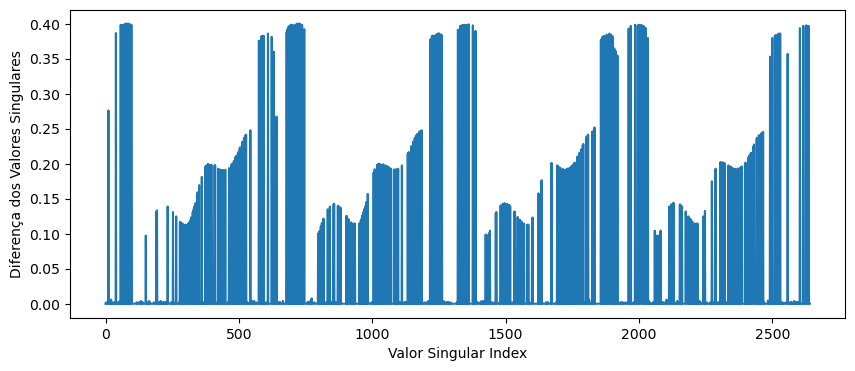

In [720]:
plt.figure(figsize=(10, 4))
plt.plot(dif51, label='Diferença dos Valores Singulares')
plt.xlabel('Valor Singular Index')
plt.ylabel('Diferença dos Valores Singulares')
plt.show()

#### Teste 5.2

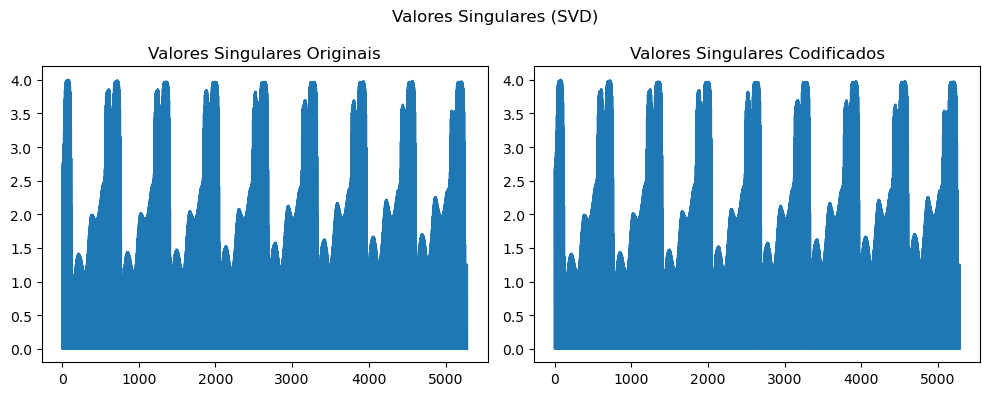

In [721]:
#Visualizando a mudança nos valores singulares
valores_singulares_originais52 = np.array(sList52).flatten()
valores_singulares_codificados52 = np.array(sListCoded52).flatten()

fig, axs = plt.subplots(1, 2,  figsize=(10, 4))
fig.suptitle("Valores Singulares (SVD)")

# Plot os valores singulares da imagem original
axs[0].plot(valores_singulares_originais52, label='Original')
axs[0].set_title('Valores Singulares Originais')

# Plot os valores singulares depois da codificação
axs[1].plot(valores_singulares_codificados52, label='Encoded')
axs[1].set_title('Valores Singulares Codificados')

plt.tight_layout()
plt.show()

In [722]:
dif52 = np.abs(valores_singulares_originais52 - valores_singulares_codificados52)

In [723]:
sum(dif52)

50.54406648064353

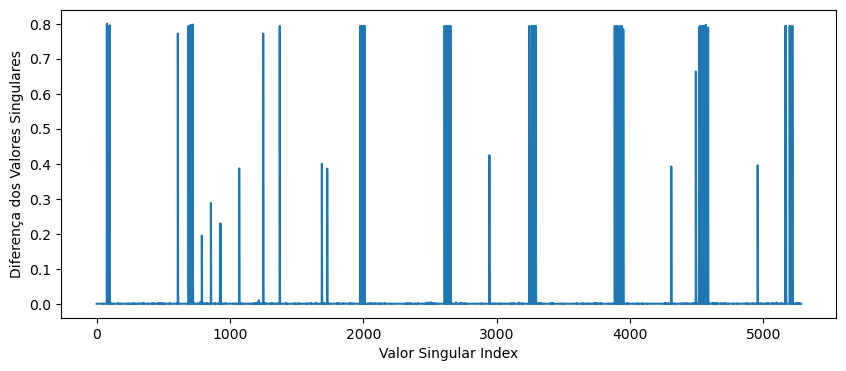

In [724]:
plt.figure(figsize=(10, 4))
plt.plot(dif52, label='Diferença dos Valores Singulares')
plt.xlabel('Valor Singular Index')
plt.ylabel('Diferença dos Valores Singulares')
plt.show()

#### Teste 5.3

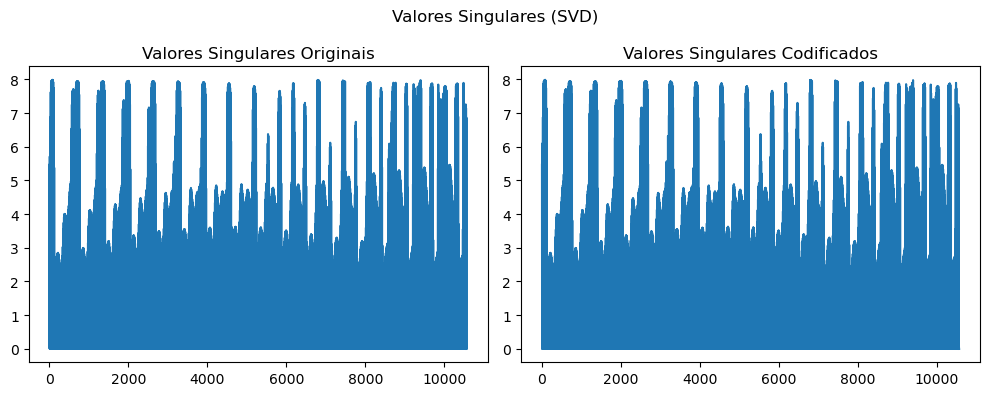

In [725]:
#Visualizando a mudança nos valores singulares
valores_singulares_originais53 = np.array(sList53).flatten()
valores_singulares_codificados53 = np.array(sListCoded53).flatten()

fig, axs = plt.subplots(1, 2,  figsize=(10, 4))
fig.suptitle("Valores Singulares (SVD)")

# Plot os valores singulares da imagem original
axs[0].plot(valores_singulares_originais53, label='Original')
axs[0].set_title('Valores Singulares Originais')

# Plot os valores singulares depois da codificação
axs[1].plot(valores_singulares_codificados53, label='Encoded')
axs[1].set_title('Valores Singulares Codificados')

plt.tight_layout()
plt.show()

In [726]:
dif53 = np.abs(valores_singulares_originais53 - valores_singulares_codificados53)

In [727]:
sum(dif53)

8.216545377915754

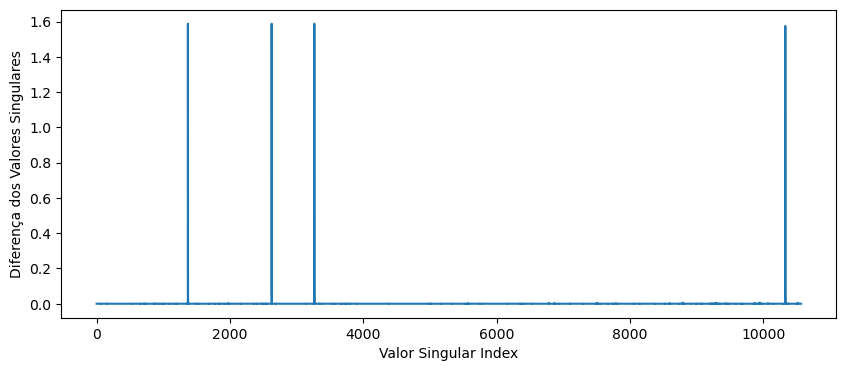

In [728]:
plt.figure(figsize=(10, 4))
plt.plot(dif53, label='Diferença dos Valores Singulares')
plt.xlabel('Valor Singular Index')
plt.ylabel('Diferença dos Valores Singulares')
plt.show()